STM code based on

Calvi, G.G., Lucic, V. and Mandic, D.P., 2019, May. Support Tensor Machine for Financial Forecasting. In ICASSP 2019-2019 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) (pp. 8152-8156). IEEE.

In [1]:
!pip install quandl
!pip install hottbox

     |████████████████████████████████| 61kB 4.6MB/s 
     |████████████████████████████████| 61kB 24.9MB/s 
     |████████████████████████████████| 2.3MB 8.3MB/s 
  Created wheel for inflection: filename=inflection-0.3.1-cp36-none-any.whl size=6076 sha256=6b5472ea2c3a7b957cb982200d47ca67016a36a33a841b187a4ad97948a2a412
  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: more-itertools 7.2.0
    Uninstalling more-itertools-7.2.0:
      Successfully uninstalled more-itertools-7.2.0
     |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
import pandas as pd
import quandl
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import bs4 as bs
import pickle
import requests
from dateutil.relativedelta import relativedelta as rd
from scipy.optimize import minimize
from sklearn.neighbors import DistanceMetric as DM
from hottbox.core import Tensor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [0]:
import numpy as np
from hottbox.core import Tensor
import copy
import time
from scipy.spatial.distance import pdist, cdist, squareform
import pickle


def save_obj(obj, name ):
    with open('./finance_data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./finance_data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def contractor(x, w, modes):
    """
    Parameters
    ----------
    x: Tensor object
    w: weights for STM to be contracted against
    modes: modes for STM to be contracted against
    Returns
    -------
    x_vec = contracted tensor along all modes except for one
    """

    temp = x.copy()
    for w, mode in zip(w, modes):
        temp.mode_n_product(np.expand_dims(w, axis=0), mode, inplace=True)
    x_vec = np.expand_dims(temp.data.squeeze(), axis=0)

    return x_vec

class LSSTM:
    def __init__(self, C=10, kernel='linear', sig2=1, max_iter=100):

        self.order = None
        self.shape = None
        self.C = C
        self.max_iter = max_iter
        self.model = {'Weights': None,
                      'Bias': 0,
                      'nIter': 0
                      }

        self.eta_history = []
        self.b_history = []
        self.orig_labels = None
        self.kernel = kernel
        self.sig2 = sig2



    def fit(self, X_train, labels):
        """
        Parameters
        ----------
        X_train: list[Tensor],  list of length M of Tensor objects, all of the same order and size
        labels: list of length M of labels +1, -1
        Returns
        -------
        """
        self.order = X_train[0].order
        self.shape = X_train[0].shape
        self._assert_data(X_train, labels=labels)

        self.orig_labels = list(set(labels))
        labels = [1 if x == self.orig_labels[0] else -1 for x in labels]

        w_n = self._initialize_weights(X_train[0].shape)

        for i in range(self.max_iter):
           # w_n_old = copy.deepcopy(weights)
            for n in range(self.order):
                #Always seems to be better if the weights are updated on the fly, rather than altogether at the
                #end of each iteration
                # eta = self._calc_eta(w_n_old, n)
                # X_m = self._calc_Xm(X_train, w_n_old, n)
                eta = self._calc_eta(w_n, n)
                X_m = self._calc_Xm(X_train, w_n, n)
                self.eta_history.append(eta)

                w, b = self._compute_weights(X_m, labels, eta, self.C, kernel=self.kernel, sig2=self.sig2)
                w = w / np.linalg.norm(w)
                w_n[n] = w


            self._update_model(w_n, b, i)
            if self._converged(): break



    def predict(self, X_test):
        """
        Parameters
        ----------
        X_test: list[Tensor]
        Returns
        -------
        y_pred: list of predicted laels
        """
        #if singleton
        if not isinstance(X_test, list):
            X_test = [X_test]

        self._assert_data(X_test)

        w_n = self.model['Weights']
        b = self.model['Bias']
        y_pred = []
        dec_values = []
        for xtest in X_test:
            temp = xtest.copy()
            for n, w in enumerate(w_n):
                temp.mode_n_product(np.expand_dims(w, axis=0), mode=n, inplace=True)
            dec_values.append(temp.data.squeeze() + b)
            y_pred.append(np.sign(temp.data.squeeze() + b))

        y_pred = [self.orig_labels[0] if x == 1 else self.orig_labels[1] for x in y_pred]
        return y_pred, dec_values



    def _assert_data(self, X_data, labels=None):
        """
        Parameters
        ----------
        X_data: list[Tensor]
        Returns
        -------
        None, just checks if all tensors have same order and dimensions, and if labels are binary
        """
        order = self.order
        shape = self.shape
        for tensor in X_data[1:]:
            assert tensor.order == order, "Tensors must all be of the same order"
            assert tensor.shape == shape, "Tensors must all have modes of equal dimensions"
            order = tensor.order
            shape = tensor.shape

        if labels is not None:
            assert len(set(labels)) == 2, "LSSTM is a binary classifier, more than two labels were passed"


    def _initialize_weights(self, shape):
        """
        Parameters
        ----------
        shape: tuple, of tensor dimensions
        Returns
        -------
        w_n: list, the initialized weights
        """
        w_n = []
        for dim in shape:
            w_n.append(np.random.randn(dim))
        return w_n


    def _calc_eta(self, w_n, n):
        """
        Parameters
        ----------
        w_n: list, of LS-STM weights
        n: int, the one to leave out
        Returns
        -------
        eta: int, parameter to be used in LS-STM optimization problem
        """

        w_n_new = [w for i, w in enumerate(w_n) if i != n]
        eta = 1
        for w in w_n_new:
            eta *= (np.linalg.norm(w)**2)
        return eta


    def _calc_Xm(self, X_data, w_n, n):
        """
        Parameters
        ----------
        X_data: list[Tensor], all the data as list of tensor objects
        w_n: list, the weights treated as constants
        n: int, the mode we're looking at
        Returns
        -------
        X_m: np.ndarray of size M x mode(n), to be passed to the LS-SVM solver
        """
        order = X_data[0].order
        w_n_new = [w for i, w in enumerate(w_n) if i != n]
        modes = [i for i in range(order) if i != n]

        result = list(map(lambda x: contractor(x, w_n_new, modes), X_data))
        X_m = np.array(result).squeeze()

        return X_m


    def _compute_weights(self, X_m, labels, eta, C, kernel, sig2):
        """
        Parameters
        ----------
        X_m: np.ndarray,  Matrix of contracted tensors along all weights except the current n
        labels: int, the labels of hte training data
        eta: int, Parameter to be used in the algo
        C: cost
        kernel: which kernel to use (linear, rbf, etc)
        Returns
        -------
        w: list, Weights for mode n
        b: int, Bias
        """
        M = X_m.shape[0]
        if kernel=='linear':
            alphas, b = self._ls_optimizer(X_m, labels, eta, C, kernel=kernel, sig2=sig2)
            w = np.sum(alphas * X_m, axis=0)
        elif kernel=='RBF':
            y = np.zeros(M)
            alphas, b = self._ls_optimizer(X_m, labels, eta, C, kernel=kernel, sig2=sig2)
            for i in range(M):
                x_star = X_m[[i]]
                X_tmp = np.delete(X_m, i, axis=0)
                l_tmp = np.delete(labels, i, axis=0)
                alpha_tmp = np.delete(alphas, i, axis=0)[:,0]
                rbf_vector = np.exp(-np.square(cdist(X_tmp, x_star)[:,0])/(2*sig2))
                y[i] = np.sum(alpha_tmp*l_tmp*rbf_vector)
            w = np.dot(np.linalg.pinv(X_m), y-b)


        return w, b



    def _ls_optimizer(self, X_m, labels, eta, C, kernel, sig2):
        """
        Parameters
        ----------
        X_m: np.ndarray,  Matrix of contracted tensors along all weights except the current n
        labels: int, the labels of hte training data
        eta: int, Parameter to be used in the algo
        C: Cost
        kernel: which kernel to use (linear, rbf, etc)
        Returns
        -------
        alphas: the alphas computed from the Lagrangian. The first alpha is the b, the bias parameter
        b = the bias parameter
        """

        M = X_m.shape[0]
        gamma = C / eta
        y_train = np.expand_dims(np.array(labels), axis=1)

        #For now, use no kernel
        if kernel=='linear':
            Omega = np.dot(X_m, X_m.transpose())
        elif kernel=='RBF':
            Omega = np.exp(-np.square(squareform(pdist(X_m))) / (2*sig2))

        left_column = np.expand_dims(np.append(np.array([0]), np.ones(M)), axis=1)
        right_block = np.append(np.expand_dims(np.ones(M), axis=0),  Omega + (1/gamma) * np.eye(M), axis=0)
        params = np.append( left_column, right_block, axis=1)

        RHS = np.append(np.array([[0]]), y_train, axis=0)

        alphas = np.dot(np.linalg.inv(params), RHS)

        b = alphas[0][0]
        alphas = alphas[1:, :]

        return alphas, b



    def _update_model(self, w, b, nIter):
        """
        Parameters
        ----------
        w: list, estimated weights
        b: int,  estimated bias
        nIter: int, current iteration number
        Returns
        -------
        None
        """
        self.model['Weights'] = w
        self.model['Bias'] = b
        self.model['nIter'] = nIter



    def _converged(self):
        """
        Parameters
        ----------
        w_n_old: list, previous computed weights
        Returns
        -------
        Boolean
        """

        self.b_history.append(self.model['Bias'])

        if len(self.b_history) > 10:
            err1 = np.diff(np.array(self.eta_history[-11:]))
            err2 = np.diff(np.array(self.b_history[-11:]))

            if np.all(np.abs(err1) < 1e-8) and np.all(np.abs(err2) < 1e-8):
                return True

        return False

In [0]:
def compute_results (rs, pos, plot=True, savefig=True):
    
    """ 
    Compute the backtest results using the original returns as a bench mark and after positioning.
        
    """
    
    benchmark = 100*rs.cumsum().apply(np.exp).mean(1)
    myperform = 100*(pos*rs.apply(np.exp)).sum(1).replace(0,1).apply(np.log).cumsum().apply(np.exp)
    
    b_sharpe = benchmark.pct_change().mean()/benchmark.pct_change().std()
    m_sharpe = myperform.pct_change().mean()/myperform.pct_change().std()
    
    b_ar = (1+benchmark.pct_change().mean())**252 - 1
    m_ar = (1+myperform.pct_change().mean())**252 - 1
    
    if plot:
        
        plt.figure(figsize=(15,5))
        benchmark.plot(linewidth=2, color='black')
        myperform.plot(linewidth=2, color='red')
        plt.title('Performance')
        plt.legend(['benchmark', 'my performance'], fontsize=15)
        plt.grid()
        
        print('Sharpe: \n benchmark: {} \n portfolio: {}'.format(round(b_sharpe,5), round(m_sharpe,5)))
        print('Annual return: \n benchmark: {} \n portfolio: {}'.format(round(100*b_ar, 3), round(100*m_ar, 3)))
        
        if savefig: plt.savefig('fig.png')
    
    return myperform

In [0]:
# Cluster tickers from WMT
tickers = ['WMT', 'KMB', 'CHD', 'PG', 'GIS', 'HRL', 'K', 'PEP', 'CAG', 'CL', 'NWL', 'HAS', 'HSY', 'VFC', 'MAS', 'CLX', 'TSN', 'CPB']

In [6]:
# Get data
quandl.ApiConfig.api_key = ''
data = {}
for ticker in tickers:
    df = quandl.get('EOD/'+ticker)[['Adj_Close', 'Adj_Volume', 'Adj_High', 'Adj_Low']]
    data[ticker] = df
    print(ticker, df.index[-1])

WMT 2019-10-18 00:00:00
KMB 2019-10-18 00:00:00
CHD 2019-10-18 00:00:00
PG 2019-10-18 00:00:00
GIS 2019-10-18 00:00:00
HRL 2019-10-18 00:00:00
K 2019-10-18 00:00:00
PEP 2019-10-18 00:00:00
CAG 2019-10-18 00:00:00
CL 2019-10-18 00:00:00
NWL 2019-10-18 00:00:00
HAS 2019-10-18 00:00:00
HSY 2019-10-18 00:00:00
VFC 2019-10-18 00:00:00
MAS 2019-10-18 00:00:00
CLX 2019-10-18 00:00:00
TSN 2019-10-18 00:00:00
CPB 2019-10-18 00:00:00


In [0]:
# Feature Engineering
for ticker in data.keys():
    df = data[ticker]
    df['intra_vol'] = (df['Adj_High']-df['Adj_Low'])/df['Adj_Close']
    df = df.drop(['Adj_High', 'Adj_Low'], 1)
    df['Adj_Close'] = df['Adj_Close'].apply(np.log).diff(1)
    data[ticker] = df 

In [8]:
for ticker in data.keys():
    data[ticker] = data[ticker].loc['2007':]
    print(data[ticker].shape)

(3222, 3)
(3222, 3)
(3222, 3)
(3222, 3)
(3222, 3)
(3222, 3)
(3222, 3)
(3222, 3)
(3222, 3)
(3222, 3)
(3222, 3)
(3222, 3)
(3222, 3)
(3222, 3)
(3222, 3)
(3222, 3)
(3222, 3)
(3222, 3)


In [0]:
WMT = data['CAG']['Adj_Close'] # Testing on WMT

In [11]:
t_step = 5
training_t = 66
preds = pd.Series(index=WMT.index[t_step+training_t:-1])

for t in WMT.index[t_step+training_t:-1]: # iterate over time 
    
    print(t)
    
    # Tensorize up to 't' -------------
    tensor_data = np.zeros((len(tickers), t_step+training_t, data[ticker].shape[1]))
    
    for ticker in tickers:

        tmp_df = data[ticker].loc[:t].iloc[-t_step-training_t:].values

        scaler = StandardScaler()
        scaler.fit(tmp_df[:-1])

        tensor_data[tickers.index(ticker), :, :] = scaler.transform(tmp_df)
    
    # Create X and y --------------
    X = []
    y = []

    for i in range(t_step, tensor_data.shape[1]):

        X_tmp = tensor_data[:, i-t_step:i, :]

        y_tmp = np.sign(tensor_data[0, :i+1, 0][-1])/2+0.5

        X.append(Tensor(X_tmp))
        y.append(int(y_tmp))

    y = np.array(y).reshape(-1)
    
    # Set up model
    mdl = LSSTM()
    mdl.fit(X[:-1],y[:-1])
    
    preds[t] = int(mdl.predict(X[-1])[0][0])
    
    print(accuracy_score(preds.dropna(), (WMT.apply(np.sign)/2+0.5)[preds.dropna().index].astype(int)))

2007-04-17 00:00:00
1.0
2007-04-18 00:00:00
0.5
2007-04-19 00:00:00
0.3333333333333333
2007-04-20 00:00:00
0.5
2007-04-23 00:00:00
0.4
2007-04-24 00:00:00
0.3333333333333333
2007-04-25 00:00:00
0.42857142857142855
2007-04-26 00:00:00
0.375
2007-04-27 00:00:00
0.4444444444444444
2007-04-30 00:00:00
0.5
2007-05-01 00:00:00
0.45454545454545453
2007-05-02 00:00:00
0.4166666666666667
2007-05-03 00:00:00
0.46153846153846156
2007-05-04 00:00:00
0.42857142857142855
2007-05-07 00:00:00
0.4
2007-05-08 00:00:00
0.4375
2007-05-09 00:00:00
0.4117647058823529
2007-05-10 00:00:00
0.4444444444444444
2007-05-11 00:00:00
0.42105263157894735
2007-05-14 00:00:00
0.4
2007-05-15 00:00:00
0.38095238095238093
2007-05-16 00:00:00
0.36363636363636365
2007-05-17 00:00:00
0.391304347826087
2007-05-18 00:00:00
0.375
2007-05-21 00:00:00
0.36
2007-05-22 00:00:00
0.38461538461538464
2007-05-23 00:00:00
0.4074074074074074
2007-05-24 00:00:00
0.39285714285714285
2007-05-25 00:00:00
0.41379310344827586
2007-05-29 00:00:

KeyboardInterrupt: ignored

Sharpe: 
 benchmark: 0.01651 
 portfolio: 0.04885
Annual return: 
 benchmark: 7.128 
 portfolio: 15.929


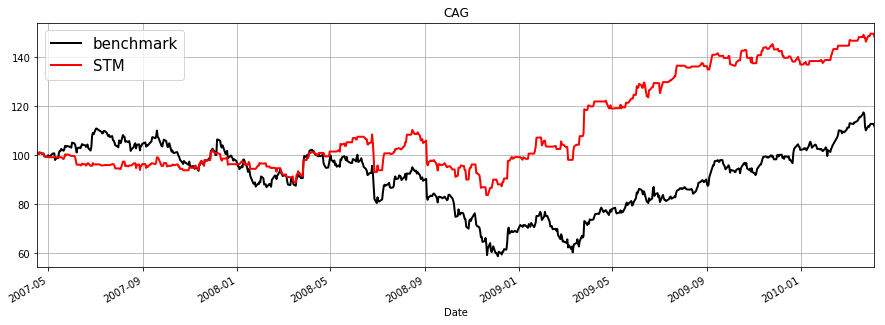

In [15]:
pos = preds.dropna()
rs = WMT.reindex(pos.index)

benchmark = 100*rs.cumsum().apply(np.exp)
myperform = 100*(pos*rs.apply(np.exp)).replace(0,1).apply(np.log).cumsum().apply(np.exp)

b_sharpe = benchmark.pct_change().mean()/benchmark.pct_change().std()
m_sharpe = myperform.pct_change().mean()/myperform.pct_change().std()

b_ar = (1+benchmark.pct_change().mean())**252 - 1
m_ar = (1+myperform.pct_change().mean())**252 - 1

plt.figure(figsize=(15,5))
benchmark.plot(linewidth=2, color='black')
myperform.plot(linewidth=2, color='red')
plt.title('CAG')
plt.legend(['benchmark', 'STM'], fontsize=15)
plt.grid()

print('Sharpe: \n benchmark: {} \n portfolio: {}'.format(round(b_sharpe,5), round(m_sharpe,5)))
print('Annual return: \n benchmark: {} \n portfolio: {}'.format(round(100*b_ar, 3), round(100*m_ar, 3)))

plt.savefig('fig.png')
from google.colab import files
files.download('fig.png')